In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
from sionna.rt import load_scene, RadioMapSolver
import inspect

from scene_objects import create_scene_objects
from motion_engine import MotionEngine

# Set Mitsuba variant
mi.set_variant("llvm_ad_mono_polarized")

In [2]:
# Get all functions in the class
for name, func in inspect.getmembers(MotionEngine, predicate=inspect.isfunction):
    sig = inspect.signature(func)
    print(f"{name}{sig}")

__init__(self, scene, bounds=None)
add_random_walk(self, jammer_id, starting_position, num_steps, step_size, time_step=0.1, z_fixed=True, random_seed=None)
create_path_matrix(self, padding_mode='pad_end')
get_all_positions_at_step(self, step_index)
get_max_path_length(self)
get_position_at_step(self, jammer_id, step_index)
update_scene_transmitters(self, step_index)


In [ ]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\testy\DowntownChicago1KM.xml"
scene = load_scene(scene_path)

In [4]:
bounds, map_center, map_size, cell_size = create_scene_objects(scene)
map_width, map_height = map_size

In [5]:
engine = MotionEngine(scene, bounds=bounds)

# Add jammer paths
engine.add_random_walk("Tx1", starting_position=[70, -10, 10], num_steps=3, step_size=10.0, time_step=1.0)
engine.add_random_walk("Tx2", starting_position=[-260, 100, 10], num_steps=5, step_size=10.0, time_step=1.0)

# Create synchronized padded paths
padded_paths, max_steps = engine.create_path_matrix(padding_mode='pad_end')

Generated path for 'Tx1': Total distance: 20.00 m, Avg velocity: 10.00 m/s
Generated path for 'Tx2': Total distance: 40.00 m, Avg velocity: 10.00 m/s
Padded 'Tx1' from 3 to 5 steps (mode: pad_end)


Tx1 position: [70.0, -10.0, 10.0]
Tx2 position: [-260.0, 100.0, 10.0]
Tx1 position: [63.2, -2.7, 10.0]
Tx2 position: [-264.2, 90.9, 10.0]
Tx1 position: [72.4, -6.5, 10.0]
Tx2 position: [-274.2, 90.8, 10.0]
Tx2 position: [-267.9, 98.6, 10.0]
Tx2 position: [-276.6, 103.6, 10.0]


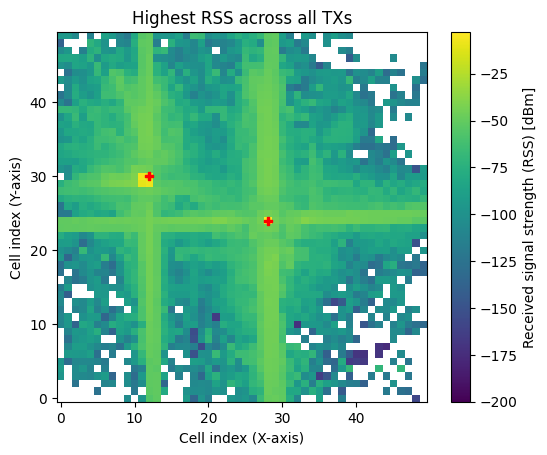

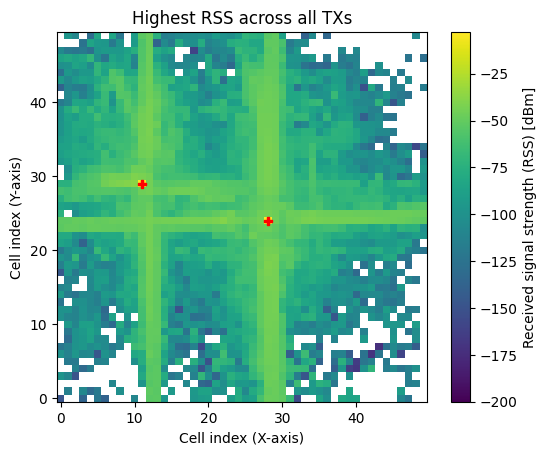

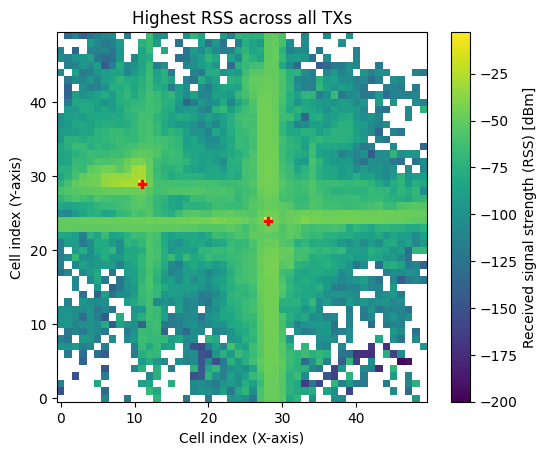

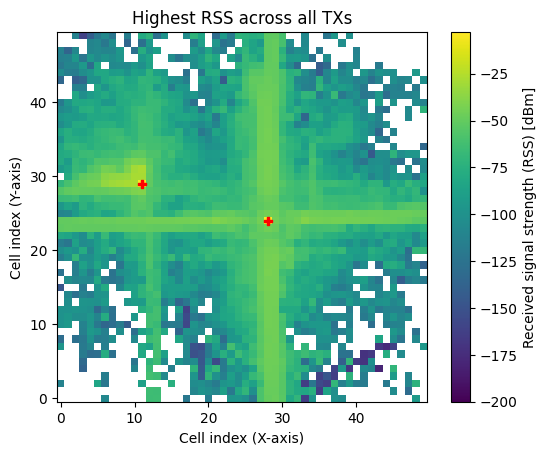

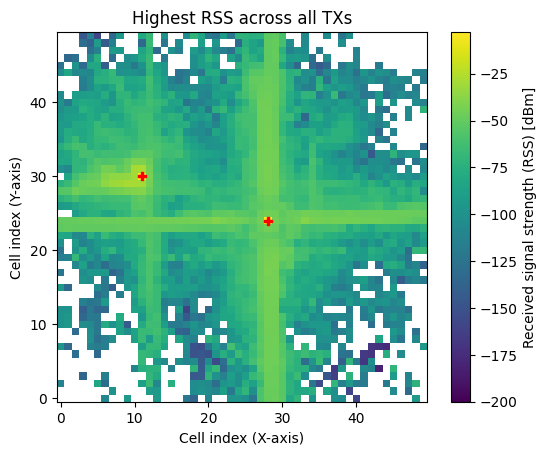

In [6]:
rm_solver = RadioMapSolver()

for step in range(max_steps):
    # Update transmitter positions
    engine.update_scene_transmitters(step)
    
    # Print current positions
    positions = engine.get_all_positions_at_step(step)
    for jammer_id, pos in positions.items():
        print(f"{jammer_id} position: [{pos[0]:.1f}, {pos[1]:.1f}, {pos[2]:.1f}]")
    
    # Compute radio map
    rm = rm_solver(
        scene,
        max_depth=10,
        samples_per_tx=10**6,  # Adjust for speed/memory
        cell_size=cell_size,
        center=map_center,
        size=[map_width, map_height],
        orientation=[0, 0, 0],
        diffraction=True,
        refraction=True,
        edge_diffraction=True
    )
    
    # Display radio map
    rm.show(metric="rss", tx=None, show_tx=True, vmin=-200)

In [7]:
print(padded_paths)

{'Tx1': array([[ 70.        , -10.        ,  10.        ],
       [ 63.21489713,  -2.654091  ,  10.        ],
       [ 72.43731347,  -6.52023079,  10.        ],
       [ 72.43731347,  -6.52023079,  10.        ],
       [ 72.43731347,  -6.52023079,  10.        ]]), 'Tx2': array([[-260.        ,  100.        ,   10.        ],
       [-264.23558183,   90.94131099,   10.        ],
       [-274.23440495,   90.78789549,   10.        ],
       [-267.93135585,   98.55137229,   10.        ],
       [-276.56992781,  103.58874011,   10.        ]])}


In [8]:
for i, obj in enumerate(scene.objects.values()):
    print(f"{obj.name} : {obj.radio_material.name} ")
    if i > 10:
        break

Chicago_Water_Tower-itu_concrete : itu_concrete 
Chicago_Water_Tower-itu_metal : itu_metal 
Plane : itu_concrete 
no-name-1 : itu_concrete 
no-name-2 : itu_metal 
